In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import argparse
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import seaborn as sns
from tqdm import tqdm
import datetime
import calendar
from collections import defaultdict


def report_metrics(y_true, y_pred):
    '''
    Output metrics of predictions vs truth
    '''
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, mape, r2


def month_str(time):
    '''
    Returns two strings representing the first and last day of time's month
    '''
    if time.month < 10:
        month_str = "0" + str(time.month)
    else:
        month_str = str(time.month)

    start_str = str(time.year) + "-" + month_str + "-01 00:14:00"
    last_day = calendar.monthrange(time.year, time.month)[1]
    end_str = str(time.year) + "-" + month_str + "-" + str(last_day) + " 23:59:00"
    return start_str, end_str


def year_str(time):
    '''
    Returns two strings representing the first and last day of time's year
    '''
    start_time = str(time.year) + "-01-01 00:14:00"
    end_time = str(time.year) + "-12-31 23:59:00"
    return start_time, end_time



class Normalised_Flow_Model:
    def __init__(self, train_report):
        self.time_range = pd.date_range("2019-01-01 00:14:00", "2022-04-08 23:59:00", freq="15min")
        # Don't include out of sync time values
        train_report_in_range = train_report[train_report.timestamp.isin(self.time_range)]
        self.predictions = train_report_in_range.groupby('timestamp')['total_volume_normalised'].median().to_frame().reset_index()
        self.true_mu = self.predictions.total_volume_normalised.sum() / len(self.time_range)
        self.empty_times = []
        
    def check_empties(self):
        for t in tqdm(self.time_range):
            if len( self.predictions[self.predictions.timestamp==t] ) <1:
                self.empty_times.append(t)
                
        print(f"{len(self.empty_times)} of {len(self.time_range)} time values are empty, {len(self.empty_times)/len(self.time_range) *100} %")
        
    def N(self,t):
        result = self.predictions[self.predictions.timestamp == t]
        if len(result) == 1:
            N_t = result.total_volume_normalised.to_numpy().item()
        else:
            N_t = 0
        return N_t
    
    
    def mean_N(self, date_range):
        '''
        Returns the average normalised volume over date_range
        '''
        N_t_in_date_range = self.predictions[self.predictions.timestamp.isin(date_range)]
        mean_N_t = N_t_in_date_range.total_volume_normalised.sum()/len(date_range)
        return mean_N_t
    
    def mean_N_year(self, time):
        '''
        Returns a prediction for the average normalised volume over a year
        '''
        # Get two strings representing the start and end of the year
        start_time, end_time = year_str(time)
        # Use these strings to create a daterange
        date_range = pd.date_range(start_time, end_time, freq="15min")
        
        mean_N_t = self.mean_N(date_range)
        return mean_N_t
        
        
    def mean_N_month(self, time):
        '''
        Returns a prediction for the average normalised volume over a month
        '''
        # Get two strings representing the start and end of the month
        start_time, end_time = month_str(time)
        # Use these strings to create a daterange
        date_range = pd.date_range(start_time, end_time, freq="15min")
        
        mean_N_t = self.mean_N(date_range)
        return mean_N_t

In [2]:
def get_reports(test_loc):
    test_report = pd.concat([v for k,v in reports.items() if k == test_loc])
    train_report = pd.concat([v for k,v in reports.items() if k != test_loc])
    return train_report, test_report

### Import Reports

In [3]:
# Import Traffic count predictions
traffic_predictions = pd.read_feather('predictions/traffic-counts/yolov5--Separate-Directions-LiveSpeed-RecallAdjusted')

# Import the traffic data to produce median models
clean_birmingham_report_df_norm = pd.read_feather('high_quality_traffic_reports_two_year/clean_birmingham_report_df_norm')
clean_manchester_report_df_norm = pd.read_feather('high_quality_traffic_reports_two_year/clean_manchester_report_df_norm')
clean_cambridge_report_df_norm = pd.read_feather('high_quality_traffic_reports_two_year/clean_cambridge_report_df_norm')
clean_thorpe_report_df_norm = pd.read_feather('high_quality_traffic_reports_two_year/clean_thorpe_report_df_norm')
clean_epping_report_df_norm = pd.read_feather('high_quality_traffic_reports_two_year/clean_epping_report_df_norm')
clean_bristol_report_df_norm = pd.read_feather('high_quality_traffic_reports_two_year/clean_bristol_report_df_norm')

# Import the reports that have the yearly data for all the sites
image_year_report_birmingham = pd.read_feather('image_year_traffic_reports/clean_birmingham_report_df')
image_year_report_manchester = pd.read_feather('image_year_traffic_reports/clean_manc_report_df')
image_year_report_cambridge = pd.read_feather('image_year_traffic_reports/clean_cam_report_df')
image_year_report_thorpe = pd.read_feather('image_year_traffic_reports/clean_thorpe_report_df')
image_year_report_epping = pd.read_feather('image_year_traffic_reports/clean_epping_report_df')
image_year_report_bristol = pd.read_feather('image_year_traffic_reports/clean_bristol_df')

# Put the Dataframe into dicts so that they can be eaility accessed
image_year_reports = {"birmingham": image_year_report_birmingham,
          "manchester" : image_year_report_manchester,
          "cambridge" : image_year_report_cambridge,
          "thorpe" : image_year_report_thorpe,
          "epping" : image_year_report_epping,
          "bristol" : image_year_report_bristol }

reports = {"birmingham": clean_birmingham_report_df_norm,
          "manchester" : clean_manchester_report_df_norm,
          "cambridge" : clean_cambridge_report_df_norm,
          "thorpe" : clean_thorpe_report_df_norm,
          "epping" : clean_epping_report_df_norm,
          "bristol" : clean_bristol_report_df_norm }


times = {"birmingham": datetime.datetime(2021,6,15,12,14),
          "manchester" : datetime.datetime(2019,4,19,12,59),
          "cambridge" : datetime.datetime(2021,11,2,12,29),
          "thorpe" : datetime.datetime(2022,3,8,12,14),
          "epping" : datetime.datetime(2022,3,8,12,14),
          "bristol" : datetime.datetime(2020,8,8,12,14) }

In [4]:
def plot_actual_v_pred(avg_flows, avg_flow_preds, name='AADT'):
    fig, ax = plt.subplots(figsize=(5,5))
    sns.scatterplot(x=avg_flow_preds, y=avg_flows, ax=ax)
    # lims of the y=x line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    plt.plot(lims, lims, 'k-', alpha=0.5)
    plt.xlabel(f'Predicted {name}')
    plt.ylabel(f'Actual {name}')
    plt.show()

In [5]:
def model_window_satellite(test_report, time, date_range, traffic_predictions_focus, model):
    ''' 
    Function that applies a traffic model to the area test_report and the predictions from traffic_predictions_focus and outputs the results
    '''
    
    avg_flow_preds_sat = []
    avg_flow_preds = []
    avg_flows = []    
    # For each site in the test area estimate the average flow over date_range
    for sites_str in traffic_predictions_focus.sites:
        site_list = sites_str.replace(' ', '').split(',')
        
        # Obtain the true traffic flow for site_list
        test_report_site = test_report[(test_report.site_id.isin(site_list)) & (test_report.timestamp.isin(date_range))]
        avg_flow = test_report_site.groupby('time_period_ending')['total_volume'].mean().mean()
        
        # Obtain the count values for site_list
        X_t_values = test_report_site[test_report_site.timestamp == time].total_volume
        # Take the mean of these count values
        X_t = X_t_values.mean()
        # Make a prediction of avg_flow from the true counts
        avg_flow_pred = X_t/model.N(time) * model.mean_N(date_range)
        
        # Obtain the count values via satellite for site_list
        X_t_sat = traffic_predictions_focus[traffic_predictions_focus.sites == sites_str].all_vehicle_pred.to_numpy()
        # Make a prediction of avg_flow from the satellites counts
        avg_flow_pred_sat = X_t_sat/model.N(time) * model.mean_N(date_range)
        
        avg_flows.append(avg_flow)
        avg_flow_preds.append(avg_flow_pred.item())
        avg_flow_preds_sat.append(avg_flow_pred_sat.item())
        
        
    metrics_gold_counts = report_metrics(avg_flows, avg_flow_preds)
    metrics_satellite_counts = report_metrics(avg_flows, avg_flow_preds_sat)
    return avg_flows, avg_flow_preds, avg_flow_preds_sat

In [6]:
def test_area(area, model, AADT = True):
    traffic_predictions_focus = traffic_predictions[traffic_predictions.area == area]
    test_report = image_year_reports[area]
    time = times[area]
    if AADT:
        start_str, end_str = year_str(time)
    else:
        start_str, end_str = month_str(time)
        
    date_range = pd.date_range(start_str, end_str, freq="15min")
    return model_window_satellite(test_report, time, date_range, traffic_predictions_focus, model)

<AxesSubplot:xlabel='area', ylabel='count'>

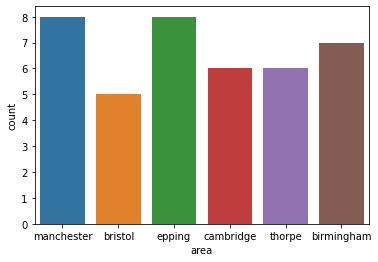

In [7]:
sns.countplot(x = traffic_predictions.area)

## Results on train vs test set

### AADT

In [8]:
AADT_sat_results = defaultdict(str)
AADT_sat_results_train = defaultdict(str)

areas = ["birmingham", "cambridge", "bristol", "manchester"]
for area in areas:
    print(area)
    
    train_report, __ = get_reports(area)
    model = Normalised_Flow_Model(train_report)
    
    AADT_sat_results[area] = test_area(area, model) # avg_flows, avg_flow_preds, avg_flow_preds_sat
    
    # Get restuls with the same model on the traiing areas
    for other_area in [other_area for other_area in areas if other_area != area ]:
        avg_flows, avg_flow_preds, avg_flow_preds_sat = [], [], []
        
        flows, flow_preds, flow_preds_sat = test_area(other_area, model)
        
        avg_flows += flows
        avg_flow_preds += flow_preds
        avg_flow_preds_sat += flow_preds_sat
        
        AADT_sat_results_train[other_area] = avg_flows, avg_flow_preds, avg_flow_preds_sat

birmingham
cambridge
bristol
manchester


In [9]:
# Print and plot results
print(",, test,test, train, train")
print(",,Satellite Traffic Count, True Traffic Count, Satellite Traffic Count, True Traffic Count")

for location, AADT_result in AADT_sat_results.items():
    avg_flows, avg_flow_preds, avg_flow_preds_sat = AADT_result
    avg_flows_train, avg_flow_preds_train, avg_flow_preds_sat_train = AADT_sat_results_train[location]
    
    mse_s, mae_s, mape_s, r2_s = report_metrics(avg_flows, avg_flow_preds_sat)
    mse_g, mae_g, mape_g, r2_g = report_metrics(avg_flows, avg_flow_preds)
    
    mse_st, mae_st, mape_st, r2_st = report_metrics(avg_flows_train, avg_flow_preds_sat_train)
    mse_gt, mae_gt, mape_gt, r2_gt = report_metrics(avg_flows_train, avg_flow_preds_train)

    print(f",MSE, {str(round(mse_s))}, {str(round(mse_g))}, {str(round(mse_st))}, {str(round(mse_gt))}")
    print(f"{location},MAE, {str(round(mae_s))}, {str(round(mae_g))}, {str(round(mae_st))}, {str(round(mae_gt))}")
    print(f",MAPE, {str(round(mape_s, 2))}, {str(round(mape_g, 2))}, {str(round(mape_st, 2))}, {str(round(mape_gt, 2))}")

,, test,test, train, train
,,Satellite Traffic Count, True Traffic Count, Satellite Traffic Count, True Traffic Count
,MSE, 9309, 6560, 8758, 5785
birmingham,MAE, 84, 62, 80, 57
,MAPE, 0.36, 0.17, 0.36, 0.17
,MSE, 14156, 462, 14058, 574
cambridge,MAE, 102, 19, 103, 21
,MAPE, 0.29, 0.06, 0.3, 0.07
,MSE, 25670, 5137, 22515, 4609
bristol,MAE, 138, 59, 128, 48
,MAPE, 0.37, 0.16, 0.34, 0.13
,MSE, 44838, 12567, 36830, 7898
manchester,MAE, 196, 95, 181, 72
,MAPE, 0.33, 0.16, 0.3, 0.13


### AMDT

In [10]:
AMDT_sat_results = defaultdict(str)
AMDT_sat_results_train = defaultdict(str)

areas = ['birmingham', 'manchester', 'cambridge', 'thorpe', 'epping', 'bristol']
for area in areas:
    print(area)
    
    train_report, __ = get_reports(area)
    model = Normalised_Flow_Model(train_report)
    
    AMDT_sat_results[area] = test_area(area, model, AADT = False) # avg_flows, avg_flow_preds, avg_flow_preds_sat
    
    # Get restuls with the same model on the traiing areas
    for other_area in [other_area for other_area in areas if other_area != area ]:
        avg_flows, avg_flow_preds, avg_flow_preds_sat = [], [], []
        
        flows, flow_preds, flow_preds_sat = test_area(other_area, model, AADT = False)
        
        avg_flows += flows
        avg_flow_preds += flow_preds
        avg_flow_preds_sat += flow_preds_sat
        
        AMDT_sat_results_train[other_area] = avg_flows, avg_flow_preds, avg_flow_preds_sat

birmingham
manchester
cambridge
thorpe
epping
bristol


In [11]:
# Print and plot results
print(",, test,test, train, train")
print(",,Satellite Traffic Count, True Traffic Count, Satellite Traffic Count, True Traffic Count")

for location, AMDT_result in AMDT_sat_results.items():
    avg_flows, avg_flow_preds, avg_flow_preds_sat = AMDT_result
    avg_flows_train, avg_flow_preds_train, avg_flow_preds_sat_train = AMDT_sat_results_train[location]
    
    mse_s, mae_s, mape_s, r2_s = report_metrics(avg_flows, avg_flow_preds_sat)
    mse_g, mae_g, mape_g, r2_g = report_metrics(avg_flows, avg_flow_preds)
    
    mse_st, mae_st, mape_st, r2_st = report_metrics(avg_flows_train, avg_flow_preds_sat_train)
    mse_gt, mae_gt, mape_gt, r2_gt = report_metrics(avg_flows_train, avg_flow_preds_train)

    print(f",MSE, {str(round(mse_s))}, {str(round(mse_g))}, {str(round(mse_st))}, {str(round(mse_gt))}")
    print(f"{location},MAE, {str(round(mae_s))}, {str(round(mae_g))}, {str(round(mae_st))}, {str(round(mae_gt))}")
    print(f",MAPE, {str(round(mape_s, 2))}, {str(round(mape_g, 2))}, {str(round(mape_st, 2))}, {str(round(mape_gt, 2))}")

,, test,test, train, train
,,Satellite Traffic Count, True Traffic Count, Satellite Traffic Count, True Traffic Count
,MSE, 9299, 5459, 8743, 4602
birmingham,MAE, 83, 59, 78, 53
,MAPE, 0.33, 0.15, 0.33, 0.15
,MSE, 40408, 9949, 33893, 6542
manchester,MAE, 187, 84, 174, 65
,MAPE, 0.32, 0.15, 0.3, 0.12
,MSE, 14311, 606, 14381, 512
cambridge,MAE, 105, 21, 105, 19
,MAPE, 0.28, 0.05, 0.28, 0.05
,MSE, 1905, 1627, 1892, 1573
thorpe,MAE, 33, 31, 34, 32
,MAPE, 0.04, 0.04, 0.04, 0.04
,MSE, 34737, 2250, 33675, 2190
epping,MAE, 145, 44, 142, 43
,MAPE, 0.21, 0.07, 0.21, 0.07
,MSE, 38319, 10789, 38476, 10668
bristol,MAE, 155, 74, 156, 73
,MAPE, 0.3, 0.14, 0.3, 0.14


## Local Model vs Global Model

### AADT

### ADMT